# NOTEBOOK 3b: MODELING - Manual Feature Selection 

Since many of the features selected by variance threshold and kbest were colinear we will use recursive runs through the lr model to identify and drop these columns so we can streamline predictions with more sophisticated algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import re
import time

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(42)

%matplotlib inline

In [2]:
df = pd.read_csv('../data/train_clean.csv', index_col='Id', na_filter=False)

Loading the clean dataframe from Notebook 02 and confirming correct indexing.

In [3]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,Central Air,...,Misc Feature_none,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,
109,0.0,13517,6,8,1976,2005,289.0,192.0,725.0,1,...,1,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,132.0,276.0,913.0,1,...,1,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,0.0,326.0,1057.0,1,...,1,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,384.0,384.0,1,...,1,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,676.0,676.0,1,...,1,0,0,0,0,0,0,0,0,1


In [4]:
df.drop([        
        'Garage Finish_Fin',    
        'Garage Finish_RFn',
        'Garage Finish_Unf',
        'Garage Finish_none',
        'Garage Cars',
        'TotRms AbvGrd',
        'Bsmt Unf SF',
        'BsmtFin SF', 
        
        'Garage Qual_none',        
        'Garage Cond_none', 

        'Bsmt Exposure_none',
        ], axis=1, inplace=True)

Dropping the features identified as colinear in Notebook 03a. Since these often outweigh features that are better predictors, these will prevent our models from acheiving the best fit. While the lasso model can apply a beta=0 to prevent this effect, ridge will still be impacted, though not as heavily as lr.

- Run 1:'Garage Finish_Fin','Garage Finish_RFn','Garage Finish_Unf','Garage Finish_none','Garage Cars','TotRms AbvGrd','Bsmt Unf SF','BsmtFin SF'
  
- Run 2:'Garage Qual_none','Garage Cond_none',
        
- Run 3:'Bsmt Exposure_none'

In [5]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(0)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=37)),
    ('lr', LinearRegression()), 
#     ('lasso', LassoCV()),
#     ('ridge', RidgeCV()),
#     ('enet', ElasticNetCV()),
#     ('knn', KNeighborsRegressor),
])


In [7]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a22c80f28>)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [9]:
pipe.score(X_train,y_train)

0.8401112266305261

In [10]:
pipe.score(X_test,y_test)

0.888200722527551

In [11]:
params = {
    'var_thresh__threshold': [0, .001, .01, .02, .05],
    'kbest__k': [5, 7, 13, 17, 23, 37, 53, 79],
#     'lasso__alpha': np.logspace(-3, 3, 7),
}

In [12]:
gs = GridSearchCV(pipe, params, cv=5, scoring='r2', verbose=1)

In [13]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a22c80f28>)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_thresh__threshold': [0, 0.001, 0.01, 0.02, 0.05], 'kbest__k': [5, 7, 13, 17, 23, 37, 53, 79]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [14]:
gs.best_params_

{'kbest__k': 79, 'var_thresh__threshold': 0}

After eliminating the first round of colinear features, the optimal hyperparameters have remained unchanged. This held true for two more subsequent runs. 

In [15]:
columns = X.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

X_weights = pd.DataFrame(gs.best_estimator_.named_steps['lr'].coef_, 
             index = columns, 
             columns=['weight'])
X_weights['abs_weight'] = X_weights['weight'].abs()

In [16]:
X_weights.sort_values(['abs_weight'],ascending=False)

,weight,abs_weight
Overall Qual,12824.825562,12824.825562
1st Flr SF,11110.323926,11110.323926
Kitchen Qual_Ex,11092.439631,11092.439631
2nd Flr SF,9879.557550,9879.557550
Garage Type_Attchd,8828.146386,8828.146386
Garage Area,8777.562923,8777.562923
Neighborhood_NridgHt,7571.334289,7571.334289
Garage Qual_TA,-7251.117146,7251.117146
Garage Type_Detchd,6800.992160,6800.992160
Neighborhood_NoRidge,6403.134087,6403.134087


After 3 runs we finally have beta coefficients that are reasonably scaled to our data. The features represented align with the correlations seen in EDA and match up with our intuitive sense of what would impact home value.

In [17]:
def md_coef_table(labels, weights):
    print('| feature | weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels[i]} | {weights[i]:.2e} |')

In [18]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight']
labels = weights.index

In [19]:
md_coef_table(labels, weights);

| feature | weight |
| --- | --- |
| Overall Qual | 1.28e+04 |
| 1st Flr SF | 1.11e+04 |
| Kitchen Qual_Ex | 1.11e+04 |
| 2nd Flr SF | 9.88e+03 |
| Garage Type_Attchd | 8.83e+03 |
| Garage Area | 8.78e+03 |
| Neighborhood_NridgHt | 7.57e+03 |
| Garage Qual_TA | -7.25e+03 |
| Garage Type_Detchd | 6.80e+03 |
| Neighborhood_NoRidge | 6.40e+03 |
| Bsmt Qual_Ex | 6.12e+03 |
| Bsmt Exposure_Gd | 5.19e+03 |
| Kitchen Qual_Gd | 5.09e+03 |
| Neighborhood_StoneBr | 4.80e+03 |
| Baths | 4.76e+03 |
| Garage Type_BuiltIn | 4.75e+03 |
| Neighborhood_Edwards | -4.58e+03 |
| Gr Liv Area | 4.57e+03 |
| Lot Area | 4.31e+03 |
| Neighborhood_Somerst | 4.24e+03 |
| Garage Qual_Fa | -4.18e+03 |
| Bsmt Baths | 4.15e+03 |
| Mas Vnr Type_None | 4.00e+03 |
| Exter Qual_Ex | 3.95e+03 |
| Sale Type_New | 3.94e+03 |
| Roof Style_Hip | 3.36e+03 |
| Condition_Street | -3.26e+03 |
| MS Zoning_RL | 3.15e+03 |
| Mas Vnr Type_BrkFace | 3.04e+03 |
| Heating QC_TA | -3.04e+03 |
| Exter Qual_Gd | 2.66e+03 |
| Kitchen Qual_

In [20]:
beta0 = gs.best_estimator_.named_steps['lr'].intercept_
beta0

180368.8058631922

Beta0 is still effectively the mean of our y_test.

In [21]:
gs.score(X_train,y_train)

0.8661409078862077

In [22]:
gs.score(X_test,y_test)

0.9058140928141567

Interestingly, out train and test scores have not changed after eliminating colinear features.

In [23]:
preds = gs.predict(X_test)

In [24]:
r2_score(preds, y_test)

0.8916117934549042

In [25]:
(mean_squared_error(preds, y_test))**.5

25468.595872096106

The model did score better on the r2 and RMSE after feature selection. 

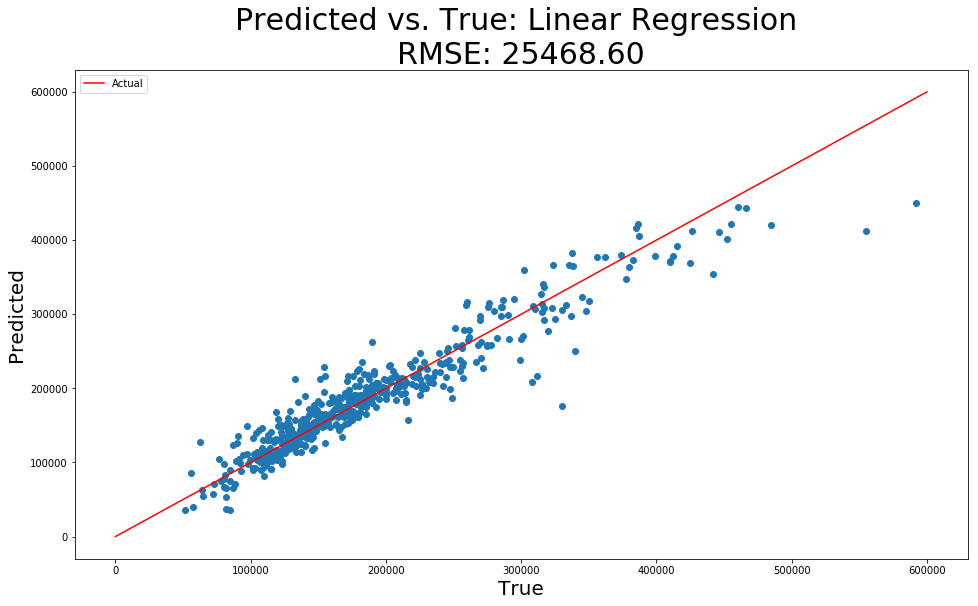

In [26]:
plt.figure(figsize=(16,9))
plt.title(f'Predicted vs. True: Linear Regression \nRMSE: {mean_squared_error(y_test, gs.predict(X_test))**.5:.2f}', fontsize=30);

plt.scatter(y_test, gs.predict(X_test))
plt.plot([0, 600000], [0, 600000], color='r')

plt.ylabel('Predicted', fontsize=20)
plt.xlabel('True', fontsize=20)
plt.legend(['Actual'])
 
    
#plt.savefig('../images/lr_MFS_preds.png', dpi=300)

Visually, there is little change in the distribution of true vs. predicted values.

## Plotting Beta Weights

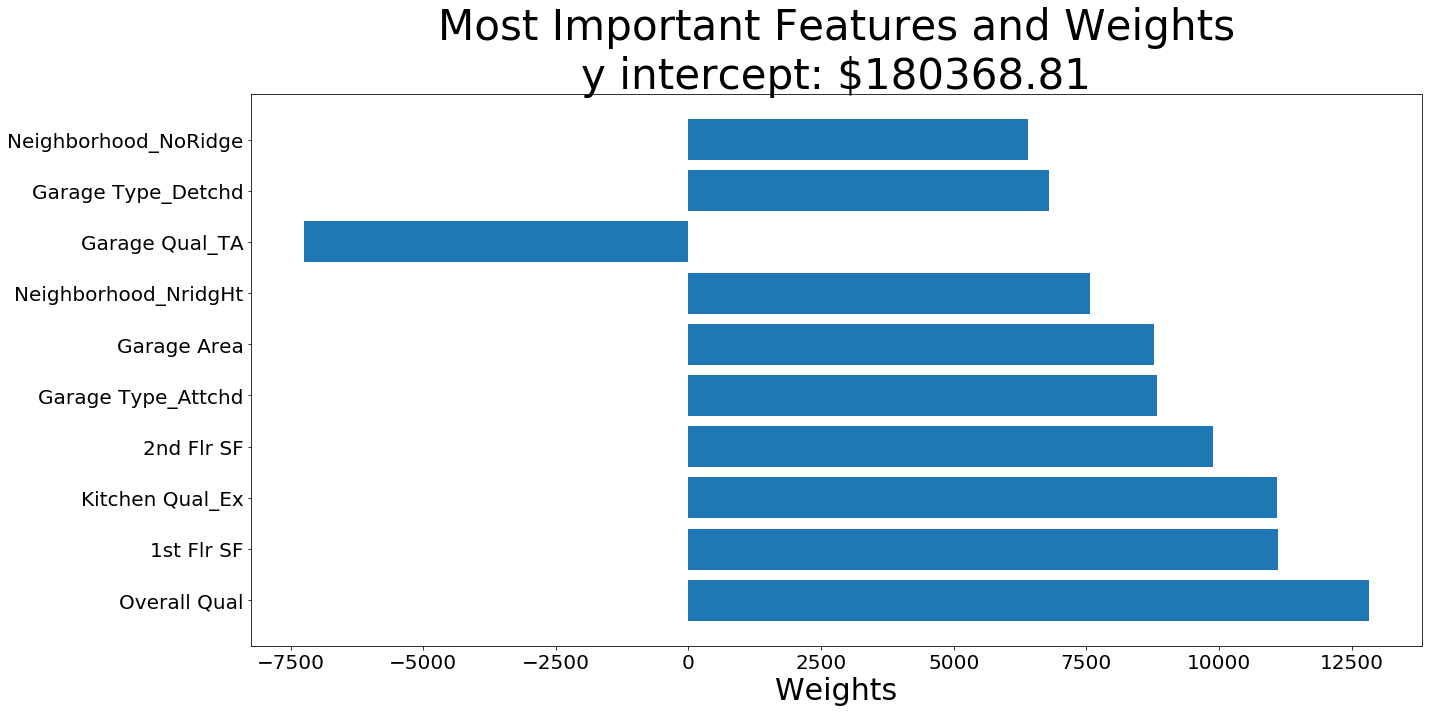

In [27]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight'].head(10)
beta_0 = gs.best_estimator_.named_steps['lr'].intercept_
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

#plt.savefig('../images/lr_MFS.png', dpi=300)

Our top ten features impacting model predictions are now much more representative. It is interesting that features relating to the garage still account for 4/10 predictors.

In [33]:
X_train.shape

(1535, 243)

Noting shape of training data to ensure complete preprocessing of unseen testing data.

# Saving out column names and scaled data for use in future models.

Function to save out files with a clear description of each run. Source: Douglas Strodman.

In [29]:
def filename_format_log(file_path, #path for saving out file of interest
                        logfile='../assets/file_log.txt', #default value
                        now=round(time.time()), #time in epoch time
                        file_description=None): 
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() #regx arg to search string for patterns 
                                                                    #(period not followed or preceeded by a period or follows string)
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}' #capture everything to (.) and then add (_) time
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Saving columns that were retained by the model

In [30]:
columns = X_train.columns

In [31]:
formatted_name, now, file_description= filename_format_log('../assets/columns.pkl')

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

Please provide a brief description:  Clean run for Kaggle


In [32]:
formatted_name, _, _= filename_format_log('../assets/gs.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(gs, f)